In [20]:
import pickle
import os
import sys
from statistics import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
working_dir = os.getcwd()
os.chdir("../../..")
sys.path.append(os.getcwd())
from Internal_Representation.state import State
from Solver.action_tracker import ActionTracker
from runner import Runner
os.chdir(working_dir)

In [21]:
# Load pickled Object
def load_pickled_ob(file_name):
    with (open(file_name, "rb")) as openfile:
        while True:
            try:
                return pickle.load(openfile)
            except EOFError:
                break

In [22]:
# Display pickled actions_taken
def display_actions_taken(actions):
    for a in actions:
        print(a)

In [23]:
# Display pickled final state
def display_final_state(final_state):
    print(final_state)

In [24]:
class average_time:
    def __init__(self):
        self.times = {} # {'roverp0': float}
        self.num_models = {}    # {'roverp0': float}

    def calculate_average_time(self, problem_name: str, times: list) -> None:
        self.times[problem_name] = mean(times)

    def calculate_average_model(self, problem_name: str, num_models: list) -> None:
        self.num_models[problem_name] = mean(num_models)

    def get_num_models(self, problem_name: str) -> float:
        return self.num_models[problem_name]

    def __getitem__(self, item):
        return self.times[item]

In [25]:
def generate_graph(example_names: list, config_names: list, colours: list, values: list,
                   title="Average Time Taken for Solving", y_axis="Average Time Taken (Seconds)"):
    assert len(config_names) == len(colours) == len(values)
    assert all([len(x) == len(example_names) for x in values])
    plt.figure(figsize=(18, 8))

    i, l = 0, len(config_names)
    while i < l:
        plt.plot([values[i][y] for y in range(len(values[i]))], 'bo-', label=r'{}'.format(config_names[i]), color=colours[i], alpha=0.6, linewidth=3)
        i += 1
    plt.xticks(range(0, len(example_names)), example_names)
    plt.locator_params(axis='x', nbins=len(example_names))
    plt.xlabel('Problem Name'); plt.ylabel(r'{}'.format(y_axis))
    plt.title(r'{}'.format(title))
    plt.legend(loc='best')
    # plt.savefig("{}_ABS_features_Weight_plot.svg".format('lasso - Ridge'), dpi=500)  # Save graph to file
    plt.grid()

# Running operations on collected Data

## Rover p0 -> p3 with early precondition checking and without

In [26]:
"""Load data from breadth first - no early precondition checker"""
breadth_first_no_early_precon_check_data_path = os.path.join(os.getcwd(), "Archive", "rover_no_early_precon_checker", "Breadth_First_Operations.csv")
breadth_first_no_early_precon_check = pd.read_csv(breadth_first_no_early_precon_check_data_path, sep=",")

breadth_first_no_early_precon_check_av_time = average_time()
for example_name in breadth_first_no_early_precon_check.example_name.unique():

    breadth_first_no_early_precon_check_av_time.calculate_average_time(example_name, breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['time_taken'])

    breadth_first_no_early_precon_check_av_time.calculate_average_model(example_name,                               breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['search_models_created'])

breadth_first_no_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.364063,1391,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.404735,2782,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.403744,4173,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.400272,5564,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.408704,6955,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.008369,9502,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.996960,12049,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,0.976625,14596,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.325808,17143,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.127409,19690,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [27]:
"""Load data from breadth first"""
breadth_first_early_precon_check_data_path = os.path.join(os.getcwd(), "Archive", "rover_early_precon_checker", "Breadth_First_Operations.csv")
breadth_first_early_precon_check = pd.read_csv(breadth_first_early_precon_check_data_path, sep=",")

breadth_first_early_precon_check_av_time = average_time()
for example_name in breadth_first_early_precon_check.example_name.unique():

    breadth_first_early_precon_check_av_time.calculate_average_time(example_name, breadth_first_early_precon_check[breadth_first_early_precon_check['example_name'] == example_name]['time_taken'])

    breadth_first_early_precon_check_av_time.calculate_average_model(example_name, breadth_first_early_precon_check[breadth_first_early_precon_check['example_name'] == example_name]['search_models_created'])

breadth_first_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.362576,1391,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.372496,2782,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.401264,4173,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.436977,5564,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.363568,6955,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,0.959265,9502,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.997457,12049,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.123441,14596,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,0.988529,17143,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,0.956289,19690,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


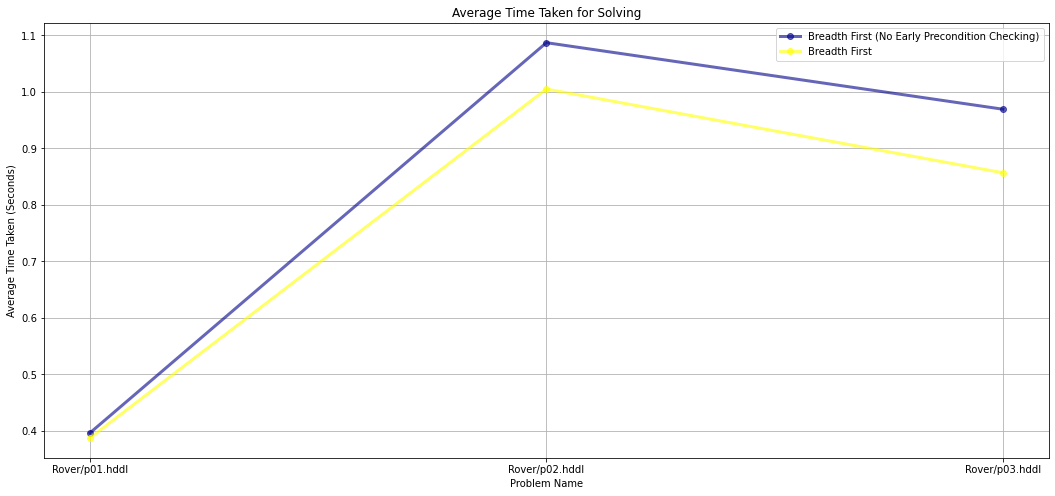

In [28]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Early Precondition Checking)", "Breadth First"], ["darkblue", "yellow"], [
[breadth_first_no_early_precon_check_av_time["Rover/p01.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p02.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p03.hddl"]],
[breadth_first_early_precon_check_av_time["Rover/p01.hddl"],
 breadth_first_early_precon_check_av_time["Rover/p02.hddl"],
 breadth_first_early_precon_check_av_time["Rover/p03.hddl"]]
])

In [29]:
"""Stats test"""

'Stats test'

## Rover p4 -> p7 with and without early precon checking

## Rover p0 -> p3 breadth first with and without data pruning. Predicate distance to goal p0 -> p3 also

In [30]:
breadth_first_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.362576,1391,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.372496,2782,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.401264,4173,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.436977,5564,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.363568,6955,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,0.959265,9502,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.997457,12049,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.123441,14596,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,0.988529,17143,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,0.956289,19690,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [31]:
"""Load data from breadth first"""
breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "rover_early_precon_checker", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.read_csv(breadth_first_pruning_data_path, sep=",")

breadth_first_pruning_av_time = average_time()
for example_name in breadth_first_pruning.example_name.unique():
    breadth_first_pruning_av_time.calculate_average_time(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['time_taken'])

    breadth_first_pruning_av_time.calculate_average_model(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['search_models_created'])

breadth_first_pruning

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.055552,263,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.062991,526,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.056048,789,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.052576,1052,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.075392,1315,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,0.082336,1734,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.083823,2153,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,0.080352,2572,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,0.096720,2991,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,0.086304,3410,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [32]:
"""Load data from Predicate distance to goal"""
predicate_distance_to_goal_data_path = os.path.join(os.getcwd(), "Archive", "rover_predicate_distance", "Predicate_Distance_To_Goal.csv")
predicate_distance_to_goal = pd.read_csv(predicate_distance_to_goal_data_path, sep=",")

predicate_distance_to_goal_av_time = average_time()
for example_name in predicate_distance_to_goal.example_name.unique():
    predicate_distance_to_goal_av_time.calculate_average_time(example_name, predicate_distance_to_goal[predicate_distance_to_goal['example_name'] == example_name]['time_taken'])

    predicate_distance_to_goal_av_time.calculate_average_model(example_name, predicate_distance_to_goal[predicate_distance_to_goal['example_name'] == example_name]['search_models_created'])

predicate_distance_to_goal

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.036705,121,serialised_objects\Rover_p01hddl_Predicate_Dis...,serialised_objects\Rover_p01hddl_Predicate_Dis...
1,Rover/p01.hddl,0.027776,242,serialised_objects\Rover_p01hddl_Predicate_Dis...,serialised_objects\Rover_p01hddl_Predicate_Dis...
2,Rover/p01.hddl,0.027280,363,serialised_objects\Rover_p01hddl_Predicate_Dis...,serialised_objects\Rover_p01hddl_Predicate_Dis...
3,Rover/p01.hddl,0.028273,484,serialised_objects\Rover_p01hddl_Predicate_Dis...,serialised_objects\Rover_p01hddl_Predicate_Dis...
4,Rover/p01.hddl,0.029264,605,serialised_objects\Rover_p01hddl_Predicate_Dis...,serialised_objects\Rover_p01hddl_Predicate_Dis...
5,Rover/p02.hddl,0.064977,825,serialised_objects\Rover_p02hddl_Predicate_Dis...,serialised_objects\Rover_p02hddl_Predicate_Dis...
6,Rover/p02.hddl,0.063983,1045,serialised_objects\Rover_p02hddl_Predicate_Dis...,serialised_objects\Rover_p02hddl_Predicate_Dis...
7,Rover/p02.hddl,0.061008,1265,serialised_objects\Rover_p02hddl_Predicate_Dis...,serialised_objects\Rover_p02hddl_Predicate_Dis...
8,Rover/p02.hddl,0.067456,1485,serialised_objects\Rover_p02hddl_Predicate_Dis...,serialised_objects\Rover_p02hddl_Predicate_Dis...
9,Rover/p02.hddl,0.071920,1705,serialised_objects\Rover_p02hddl_Predicate_Dis...,serialised_objects\Rover_p02hddl_Predicate_Dis...


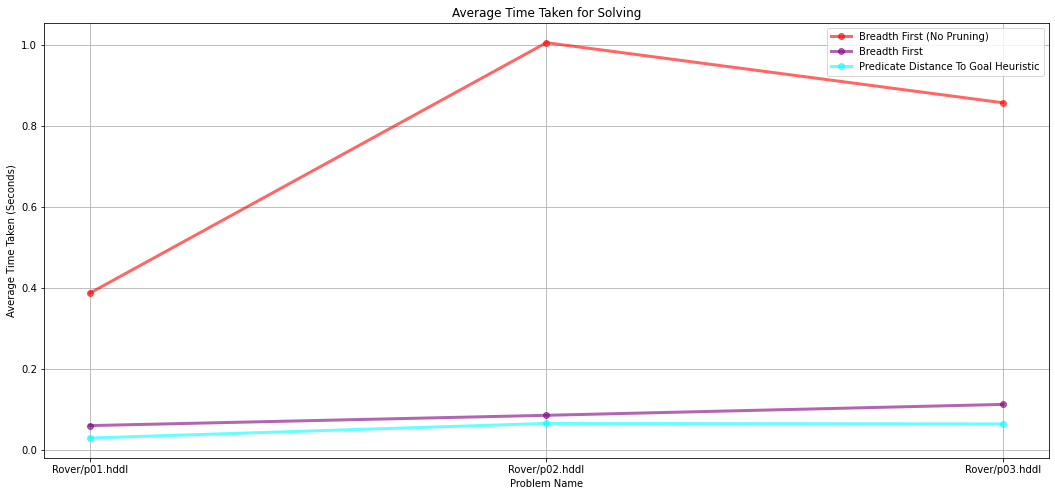

In [33]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
[
    [breadth_first_early_precon_check_av_time["Rover/p01.hddl"],
     breadth_first_early_precon_check_av_time["Rover/p02.hddl"],
     breadth_first_early_precon_check_av_time["Rover/p03.hddl"]],
    [breadth_first_pruning_av_time["Rover/p01.hddl"],
     breadth_first_pruning_av_time["Rover/p02.hddl"],
     breadth_first_pruning_av_time["Rover/p03.hddl"]],
    [predicate_distance_to_goal_av_time["Rover/p01.hddl"],
     predicate_distance_to_goal_av_time["Rover/p02.hddl"],
     predicate_distance_to_goal_av_time["Rover/p03.hddl"]]
])

## Rover p04 pruning and predicate_distance
For this test, the breadth first non-pruning search strategy was run for 2 hours and was not able to produce a result

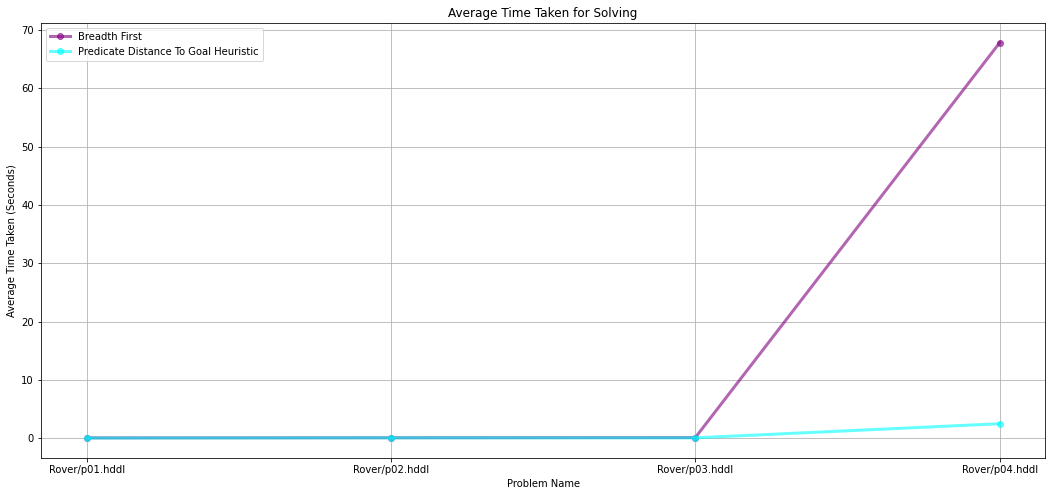

In [34]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl"],
               ["Breadth First", "Predicate Distance To Goal Heuristic"], ["purple", "aqua"],
               [
                   [breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Rover/p02.hddl"],
                    breadth_first_pruning_av_time["Rover/p03.hddl"],
                    breadth_first_pruning_av_time["Rover/p04.hddl"]],
                   [predicate_distance_to_goal_av_time["Rover/p01.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p02.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p03.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p04.hddl"]]
               ])

## Rover p0 -> p7 predicate distance to goal

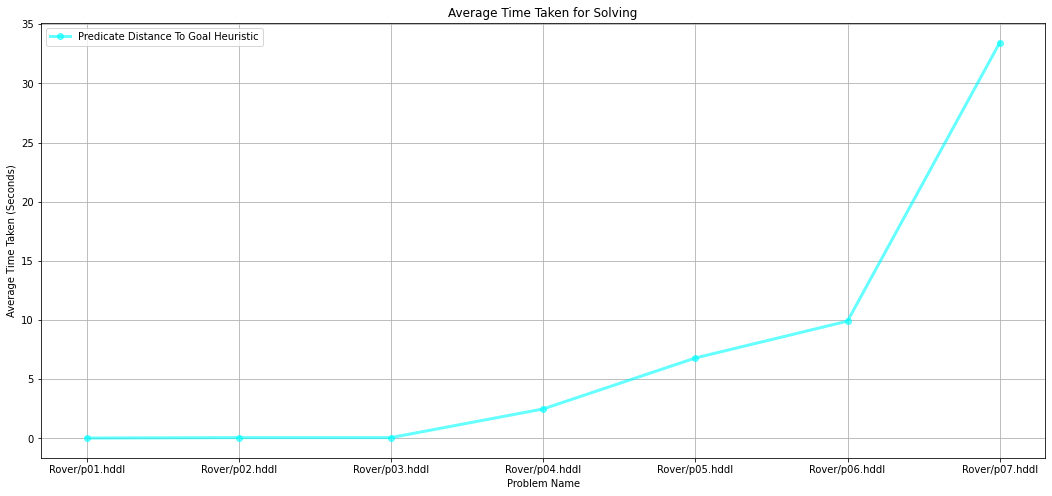

In [35]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl",
                "Rover/p06.hddl", "Rover/p07.hddl"],
               ["Predicate Distance To Goal Heuristic"], ["aqua"],
               [
                   [predicate_distance_to_goal_av_time["Rover/p01.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p02.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p03.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p04.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p05.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p06.hddl"],
                    predicate_distance_to_goal_av_time["Rover/p07.hddl"]]
               ])

# Graph number of models created during search

## Rover p0 -> p3. Breadth first, breadth first with pruning, predicate distance to goal

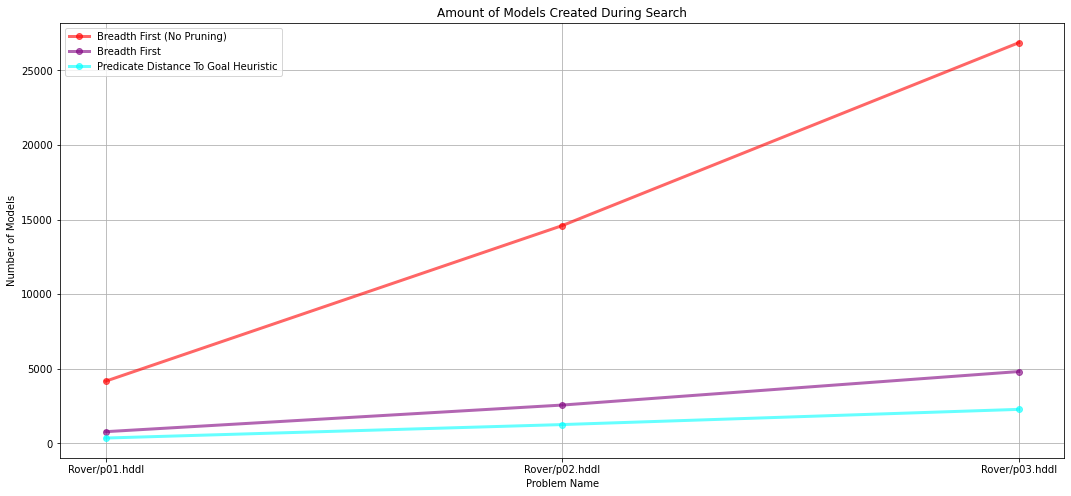

In [36]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
               [
                   [breadth_first_early_precon_check_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_early_precon_check_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_early_precon_check_av_time.get_num_models("Rover/p03.hddl")],
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl")],
                   [predicate_distance_to_goal_av_time.get_num_models("Rover/p01.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p02.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p03.hddl")]
               ], "Amount of Models Created During Search", "Number of Models")

# Area for checking serialised files

In [37]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_actions_taken']
actions_taken = load_pickled_ob(file_name)
display_actions_taken(actions_taken)

FileNotFoundError: [Errno 2] No such file or directory: 'serialised_objects\\Rover_p01hddl_Predicate_Distance_To_Goal_actions.pickle'

In [ ]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_state']
final_state = load_pickled_ob(file_name)
display_final_state(final_state)